# PINN for Burgers' Equation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Brief Overview of Burgers' Equation

The Burgers' equation is a fundamental partial differential equation used in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics and traffic flow. It is used describe both nonlinear convection and diffusion.

The one-dimensional viscous Burgers' equation is given by:

$$
\frac {\partial u}{\partial t} + u{\frac {\partial u}{\partial x}} = \nu \frac {\partial ^{2}u}{\partial x^{2}}
$$

where:

- $u(x, t)$ is velocity of a fluid as a function of space, $x$ and time, $t$.

- $\nu$ is the kinematic viscosity.

## Defining the Model Architecture

Below, we define the architecture of a model.

In [3]:
class Model(nn.Module):
    def __init__(self, hidden_channels:int, num_hidden_layers:int=3) -> None:
        super().__init__()

        self.input_layer = nn.Linear(2, hidden_channels)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels)for _ in range(num_hidden_layers)
        ])

        self.output_layer = nn.Linear(hidden_channels, 1)


    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)

        inputs = F.tanh(self.input_layer(inputs))
        
        for hidden_layer in self.hidden_layers:
            inputs = F.tanh(hidden_layer(inputs))

        return self.output_layer(inputs)

## Simulating a System

For the simulation, we will consider the following conditions and assumptions:

- The viscosity, $\nu = \frac{0.01}{\pi}$

- The initial condition is given as $u(x, 0) = - \sin(\pi x)$

- The boundary condition are imposed by $u(1, t) = u(-1, t) = 0$

- The spatial domain is defined as, $x \in [-1, 1]$ and the time interval is $t \in [0, 1]$

From Burger's Equation, we can define a function, $f$ to be represented by:

$$
f(x, t) = \frac{\partial u}{\partial t} + u{\frac {\partial u}{\partial x}} - \nu \frac {\partial ^{2}u}{\partial x^{2}}
$$


The total loss for the simuation is given by:

$$
\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{IC}
$$

This combines the boundary condition, the intial condition and the physics law of the system.

- **Physics Loss**

    $$
    \mathcal{L}_{PDE} = \frac{1}{N} \sum^{N}_{i} \left| f(x_i, t_i) \right|^2
    $$

- **Boundary Condition Loss**

    $$
    \mathcal{L}_{BC} = \frac{1}{N} \sum^{N}_{i} \left| u_{\theta}(-1, t_i) \right| ^ 2 + \frac{1}{N} \sum^{N}_{i} \left| u_{\theta}(1, t_i) \right| ^ 2
    $$

- **Initial Condition Loss**

    $$
    \mathcal{L}_{IC} = \frac{1}{N} \sum^{N}_{i} \left| u_{\theta}(x_i, 0) + \sin(\pi x_i) \right| ^ 2
    $$

In [4]:
nu = 0.01 / np.pi

x = torch.rand(1000, 1).uniform_(-1, 1).requires_grad_(True).to(device)
t = torch.rand(1000, 1).uniform_(0, 1).requires_grad_(True).to(device)

# Initial condition (x at t = 0)
x_initial = torch.rand(100, 1).uniform_(-1, 1).to(device)

# Boundary condition points (t at x = -1 and x = 1)
t_boundary = torch.rand(100, 1).uniform_(0, 1).to(device)

In [5]:
pinn = Model(hidden_channels=32, num_hidden_layers=3).to(device)
optimizer = optim.Adam(pinn.parameters(), 1e-3)

In [6]:
num_training_steps = 20000

for training_step in range(num_training_steps):
    optimizer.zero_grad()
    
    # Physics Loss
    u = pinn(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx

    loss_pde = torch.mean(f**2)

    # Boundary Condition Loss
    x_left = -torch.ones_like(t_boundary)
    x_right = torch.ones_like(t_boundary)
    
    u_left = pinn(x_left, t_boundary)
    u_right = pinn(x_right, t_boundary)
    
    loss_boundary = torch.mean(u_left**2) + torch.mean(u_right**2)

    # Initial Condition Loss
    u_pred = pinn(x_initial, torch.zeros_like(x_initial))
    u_true = -torch.sin(np.pi * x_initial).to(device)

    loss_initial = torch.mean((u_pred - u_true)**2)

    # Total Loss
    loss = loss_pde + loss_boundary + loss_initial

    loss.backward()
    optimizer.step()

    if (training_step + 1) % 1000 == 0:
        print(f'Training Step {training_step + 1}, Loss: {loss.item()}')

Training Step 1000, Loss: 0.06965683400630951
Training Step 2000, Loss: 0.040187690407037735
Training Step 3000, Loss: 0.02385915070772171
Training Step 4000, Loss: 0.023307275027036667
Training Step 5000, Loss: 0.012159010395407677
Training Step 6000, Loss: 0.007114909589290619
Training Step 7000, Loss: 0.0045064762234687805
Training Step 8000, Loss: 0.0033875196240842342
Training Step 9000, Loss: 0.0022745567839592695
Training Step 10000, Loss: 0.0019277771934866905
Training Step 11000, Loss: 0.001472024479880929
Training Step 12000, Loss: 0.0010756506817415357
Training Step 13000, Loss: 0.001064924756065011
Training Step 14000, Loss: 0.0005713910795748234
Training Step 15000, Loss: 0.0011222009779885411
Training Step 16000, Loss: 0.0006979919853620231
Training Step 17000, Loss: 0.0005390612641349435
Training Step 18000, Loss: 0.0008448057342320681
Training Step 19000, Loss: 0.0004177044320385903
Training Step 20000, Loss: 0.00046699075028300285


Let us visualize the solution.

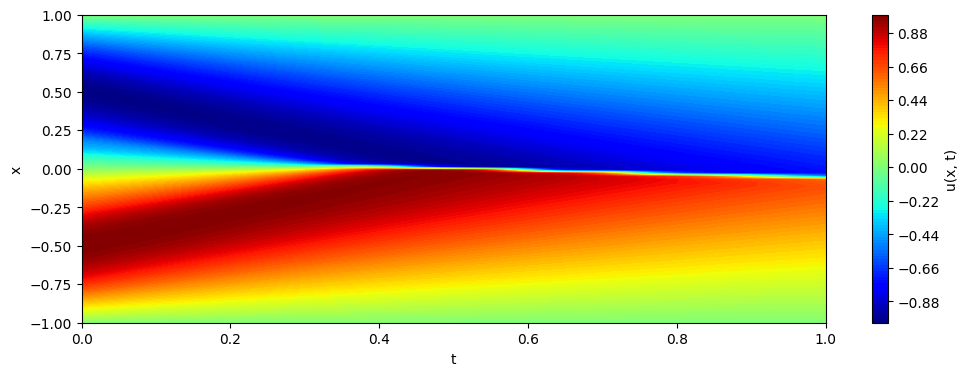

In [7]:
N = 100

x_vals = torch.linspace(-1, 1, N)
t_vals = torch.linspace(0, 1, N)

x_grid, t_grid = torch.meshgrid(x_vals, t_vals, indexing='ij')
x_flat, t_flat = x_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)

u_pred = pinn(x_flat.to(device), t_flat.to(device)).cpu().detach().numpy()
u_pred = u_pred.reshape(N, N)

plt.figure(figsize=(12, 4))
plt.contourf(t_grid, x_grid, u_pred, N, cmap='jet')
plt.colorbar(label='u(x, t)')
plt.xlabel('t')
plt.ylabel('x')
plt.show()